# A journey into Sound.

One of the most successful applications of deep learning is something that we carry around with us every day. Whether it's Google Now, or Siri, the engines that power both systems and Amazon's Alexa are neural networks. We will take a look on ```torchaudio``` library. We will construct a pipeline for classifying audio data with a convolutional-based model.

# Sound

Sound is created via the vibration of air. All the sounds we hear are combinations of high and low pressure that we often represent in a waveform, like the one following example; the wave below above the origin is high pressure, and the part below is low pressure.

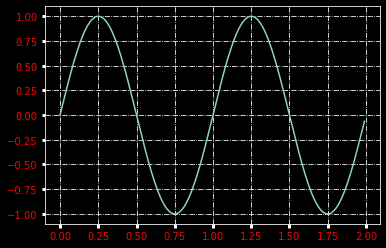

In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import gc

t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='r', labelsize='medium', width=3)

plt.show()

Now let's try something more complex than a sine wave;

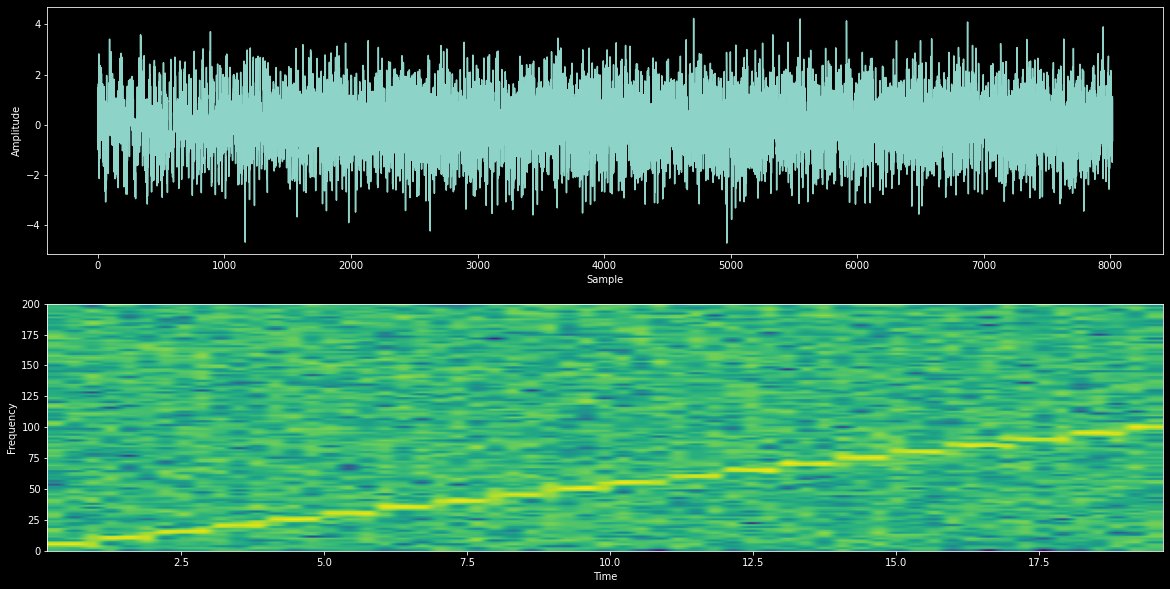

In [2]:
#Define the list of frequencies
frequencies         = np.arange(5,105,5)
# Sampling Frequency
samplingFrequency   = 400
# Create two ndarrays
s1 = np.empty([0]) # For samples
s2 = np.empty([0]) # For signal
# Start Value of the sample
start   = 1
# Stop Value of the sample
stop    = samplingFrequency+1
for frequency in frequencies:
    sub1 = np.arange(start, stop, 1)
    # Signal - Sine wave with varying frequency + Noise
    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))
    s1      = np.append(s1, sub1)
    s2      = np.append(s2, sub2)
    start   = stop+1
    stop    = start+samplingFrequency

# Plot the signal
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(s1,s2)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
# Plot the spectrogram
plt.subplot(212)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(s2, Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   

In digital sound, we *sample* this waveform many times a second, traditionally 44,100 for CD-quality sound, and store the amplitude values of the wave during each sample point. At time $t$, we have a single value stored. This is slightly different from an image, which requires two values $x$ and $y$, to store a value (for a grayscale image). If we use convolutional filters in our neural network, we need a 1D filter rather than the 2D filters we were using for images.

Now that we know a little more about sound, let's look at the dataset we use.

#  ESC-50 Dataset

The *Environmental Sound Classification (ESC)* dataset is a collection of field recordings, each of which is 5 seconds long and assigned to one of 50 classes  (e.g., a dog barking, snoring, a knock on a door). We use this set for the rest of this experiment with two ways of classifying audio, as well as to explore using ```torchaudio``` to simplify loading and manipulating audio.

*Note: get the  dataset from https://github.com/karoldvl/ESC-50/archive/master.zip*

We care about the final number in the filename, because that tells us what class this sound clip has been assigned to. The other parts of the filename don't matter to us but mostly relate to the larger Freesound dataset from which ESC-50 has been drawn (with one exception that I'll come back to shortly). If you're interested in finding out more, the README document in the ESC-50 repo goes into further detail.

Now that we've downloaded the dataset, let's look at some of the sounds it contains.

# Playing audio in Jupyter

If you want to actually hear a sound from ESC-50, then instead of loading one of the files into a standard music player, you can use  Jupyter's built-in player for audio, ```IPython.display.Audio```

In [3]:
import IPython.display as display
display.Audio('ESC-50-master/audio/train/1-100032-A-0.wav')

# Exploring ESC-50

When dealing with a new dataset, it's always a good idea to get a feeling for the *shape* of the data before you dive right into building models. In classification tasks, for example, you'll want to know whether your dataset actually contains examples from all the possible classes, and ideally that all classes are present in equal numbers. Let's take a look how ESC-50 breaks down.

*Note: If your dataset has an **unbalanced amount of data**, a simple solution is to randomly duplicate the smaller class examples until you have increased them to the number of the other classes. Although this feels like fake accounting, it's surprisingly effective (and cheap) in practice.*

We know that the final set of digits in each filename describes the class it belongs to, so what we need to do is grab a list and count up the occurrences of each class:

In [4]:
import glob
from collections import Counter

esc50_list = sorted([f.split("-")[-1].replace(".wav", "")
             for f in glob.glob("ESC-50-master/audio/*.wav")])
counter = Counter(esc50_list)

First, we build up a list of our ESC-50 filenames. Because we care about only the class number at the end of the filename, we chop off the *.wav*  extension and split the filename in the - separator. We finally take the last element in that split string. If you inspect ```esc50_list```, you'll get a bunch of strings that range from 0 to 49. We could write more code that builds a ```dict``` and counts all the occurrences for us, but ```Counter``` does that for us taking any hashable items. Here's the output.

We have one of those rare things, a perfectly balanced dataset. Now install a few more libraries we're going to need.

# SoX and LibROSA

Most of the audio processing that ```torchaudio``` carries out riles on two other pieces of software: *SoX* and *LibROSA*. *LibROSA* is a Python library for audio analysis, including generating mel spectograms (Like in the 2nd example, where we graph Frequency vs Time instead of Amplitude vs Time or Samples), detecting beats, and even generating music.

*SoX*, on the other hand, is a program that you might already be familiar with if you've using linux for years.

# torchaudio

The core of ```torchaudio``` is found within ```load()``` and ```save()```. We're concerned only with ```load()``` in this example, but maybe you'll need to use ```save()``` if you're generating new audio from the input (e.g, text-to-speech model). ```load()``` takes a file specified in ```filepath``` and returns a tensor representation of the audio file and the sample rate of that audio file as a separate variable.

We now have the means for loading one of the WAV files from the ESC-50 dataset and turning it into a tensor. Unlike our earlier work with  text and images, we need to write a bit more code before we can get on with creating and training a model. We need to write a custon ```Dataset``` class.

# Building an ESC-50 Dataset

We've talked about datasets in **Chapter 2**, but ```torchvision``` and ```torchtext``` did all the heavy lifting for us, so we didn't have to worry too much about the details. As you may remember, a custom dataset has to implement two class methods, ```___getitem___``` and ```___len___```, so that the data loader can get a batch of tensors and their labels, as well as a total count of tensors in the dataset. We also have an ```___init___``` method for setting up things like file paths that'll be used over and over again.

In [5]:
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from jupyterplot import ProgressPlot
import librosa

class ESC50Dataset(Dataset):
    
    def __init__(self, path):
        self.path = path
        # Get the directory  listing from path
        files = Path(self.path).glob('*.wav')
        # Iterate through the listing and create  a list of tuples (filename, label)
        self.items = [(str(f), f.name.split("-")[-1].replace(".wav", "")) for f in files]
        self.length = len(self.items)
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = torchaudio.load(filename)
        return audio_tensor, int(label)
    
    def __len__(self):
        return self.length

The majority of the work in the class happens when a new instance of it is created. The ```___init___``` method takes the ```path``` parameter, finds all the WAV files inside that path, and then produces tuples of ```(filename, label)``` by using the same string split we used earlier in the chapther to get the label of that audio sample. When PyTorch reques an item from the dataset, we index into the ```items``` list, use ```torchaudio`.load``` to make ```torchaudio``` load in the audio file, turn it into a tensor, and then return both the tensor and the label.

And that's enough for us to start with. For a sanity check, let's create an ```ESC50Dataset``` object and extract the first item:

In [6]:
PATH_TO_ESC50 = Path.cwd() / 'ESC-50-master/audio/'
PATH_TO_ESC50_train = PATH_TO_ESC50/ 'train'
PATH_TO_ESC50_valid = PATH_TO_ESC50/ 'valid'
PATH_TO_ESC50_test = PATH_TO_ESC50/ 'test'
test_esc50 = ESC50Dataset(PATH_TO_ESC50_train)
tensor, label = list(test_esc50)[0]
tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
tensor.shape

torch.Size([1, 220500])

In [8]:
label

0

We can construct a data loader by using PyTorch standard constructs:

In [9]:
example_loader = DataLoader(test_esc50, batch_size=64, shuffle=True)

Before we construct our ```DataLoader``` instances for ```train, valid, test``` sets, we have to go back into our data. As you might remember, we should always create a training, validation and test sets. At the moment, we have just one directory with all the data, which is no good for our purposes. A 60/20/20 split of data into training, validation and test collections should suffice. Now, we could do this by taking random samples of our entire dataset (taking care to sample without replacement and making sure that our newly constructed datasets are still balanced), but again the ESC-50 dataset saves us from having to do much work. The compilers of the dataset separated the data into five equal balanced *folds* indicated by the *first* digit in the filename. We'll have folds ```1,2,3``` be the training set, ```4``` validation set, and ```5``` the test set:

Do:

```mkdir train test valid
mv 1*  .../train
mv 2*  .../train
mv 3*  .../train
mv 4*  .../valid
mv 5*  .../test
```

Now we can create the individual datasets and loaders:


In [10]:
# batch_size = 8
# device = 'cuda'
# train_esc50 = ESC50Dataset(PATH_TO_ESC50_train)
# valid_esc50 = ESC50Dataset(PATH_TO_ESC50_valid)
# test_esc50 = ESC50Dataset(PATH_TO_ESC50_test)

# train_loader = DataLoader(train_esc50, batch_size=batch_size, shuffle=True, num_workers=2)
# valid_loader = DataLoader(valid_esc50, batch_size=batch_size, shuffle=True, num_workers=2)
# #test_loader = DataLoader(test_esc50, batch_size=batch_size, shuffle=True)

# A CNN Model for ESC-50

For our first attempt at classifying sounds, we build a a model that borrows heavily from a paper called "Very Deep Convolutional Networks for Raw Waveforms". It uses a lot of building blocks from Chapter 3, but instead of using 2D layers, we're using 1D variants as we have one fewer dimension in our audio inputs:

In [11]:
# class AudioNet(nn.Module):
    
#     def __init__(self):
#         super(AudioNet, self).__init__()
#         self.conv1 =  nn.Conv1d(100, 128, kernel_size=5, stride=4)
#         self.bn1 = nn.BatchNorm1d(128)
#         self.pool1 = nn.MaxPool1d(4)
#         self.conv2 = nn.Conv1d(128, 128, 3)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.pool2 = nn.MaxPool1d(4)
#         self.conv3 = nn.Conv1d(128, 256, 3)
#         self.bn3 = nn.BatchNorm1d(256)
#         self.pool3 = nn.MaxPool1d(4)
#         self.conv4 = nn.Conv1d(256, 512, 3)
#         self.bn4 = nn.BatchNorm1d(512)
#         self.pool4 = nn.MaxPool1d(4)
#         self.fc1 = nn.Linear(512, 50)
        
#     def forward(self, x):
#         x = x.unsqueeze(-1).view(-1, 100, 2205)
#         x = self.conv1(x)
#         x = F.relu(self.bn1(x))
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = F.relu(self.bn2(x))
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = F.relu(self.bn3(x))
#         x = self.pool3(x)
#         x = self.conv4(x)
#         x = F.relu(self.bn4(x))
#         x = self.pool4(x)
#         x = x.squeeze(-1)
#         x = self.fc1(x)
#         return x

In [12]:
# audionet = AudioNet()
# audionet.to(device)

In [13]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
        del inputs, targets, loss
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [14]:
# torch.save(audionet.state_dict(), 'audionet.pth')

In [15]:
# optimizer = torch.optim.Adam(audionet.parameters(), lr=0.001)
# logs, losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)

In [16]:
def get_index_min(logs, losses):
    # Returns a tuple of the corresponding learning rate with the min loss
    min_loss = min(losses)
    min_loss_index = losses.index(min_loss)
    return min_loss, logs[min_loss_index]

In [17]:
# min_loss, opt_log = get_index_min(logs, losses)

In [18]:
# fig, ax = plt.subplots()
# ax.scatter(opt_log, min_loss, alpha=0.5)
# ax.axhline(y=min_loss, color='r')
# ax.semilogx(logs, losses)
# ax.set(xlabel='Learning Rate', ylabel='Losses',
#        title='Learning Rates')
# ax.grid()
# plt.show()

In [19]:
# lr = 1e-3
# audionet.load_state_dict(torch.load('audionet.pth'))
# optimizer = torch.optim.Adam(audionet.parameters(), lr=lr)

In [20]:
# def run_model(inputs, model, batch):
#     oom = False
#     try:
#         output = model(inputs)
#     except RuntimeError:
#         oom = True
    
#     if oom:
#         for _ in range()
        

In [38]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):
    pp = ProgressPlot(line_names=['Validation Loss', 'Training Loss', 'Accuracy'],
#                       plot_names=['Loss', 'Accuracy'],
                      x_lim=[0, epochs],
#                       y_lim=[0,1],
                      x_label='Epoch')
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            if torch.cuda.is_available():
                optimizer.zero_grad()
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_fn(output, targets)
                loss.backward()
                optimizer.step()
                training_loss += float(loss.data.item() * inputs.size(0))
                del inputs, loss, output
                gc.collect()
                if device == 'cpu':
                    continue
                else:
                    with torch.cuda.device(device):
                        torch.cuda.empty_cache()
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        
        for batch in val_loader:
            if torch.cuda.is_available():
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets) 
                valid_loss += float(loss.data.item() * inputs.size(0))
                correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
                del inputs, loss, output
                gc.collect()
                if device == 'cpu':
                    continue
                else:
                    with torch.cuda.device(device):
                        torch.cuda.empty_cache()
        valid_loss /= len(val_loader.dataset)
        accuracy = num_correct / num_examples
        pp.update([[valid_loss, training_loss, accuracy]])
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}, Memory Used: {}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples, torch.cuda.memory_allocated(device=device)), end='\r', flush=True)
    pp.finalize()

In [22]:
# train(audionet, optimizer, torch.nn.CrossEntropyLoss(), train_loader, valid_loader, epochs=10, device=device)

After training, the model attains around 13-17% accuracy on our dataset. That's better than the 2% we could expect, if we were just picking one of the 50 classes at random. But Perphaps we can do better, let's investigate a different way of looking at our audio data that may yield better results.

# Frequency.

If we look back at the GitHub page for ESC-50, you'll see a leaderboard of network architechtures and their accuracy scores. You'll notice that in comparison, we're not doing  great. We could extend the model we've created to be deeper, and that would likely increase our accuracy a little, but for real increase in performance, we need to switch domains. In audio processing, you can work on the pure waveform as we've been doing; but most of the time, you'll for in the *frequency domain*. This is different representation transforms the raw waveform into a view that  shows all the frequencies of sound  at given point in time. This is perhaps a more information-rich-representation to present to a neural network, as it'll be able to work on those frequencies directly, rather than having to work out how to map the raw waveform signal into something the model can use.

Let's look at thow to generate frequency spectograms with *LibROSA*

# Mel Spectograms

Traditionally, getting into the frequency domain requires to apply the Fourier transform on the audio signal. We're going to go beyond that little by little generating our spectograms in the mel scale. The *mel* scale defines a  scale of pitches that are equal in distance from another, where 1000mels = 1000hz. This scale is commonly used in audio processing, especially in speech recognition and classification applications. Producing a mel spectogram with *LibROSA* requires two lines of code:

In [23]:
sample_data, sr = librosa.load('ESC-50-master/audio/train/1-100032-A-0.wav', sr=None)
spectogram = librosa.feature.melspectrogram(sample_data, sr=sr)

This results in a NumPy array containing the spectogram data. If we display this spectogram, we can see the frequencies of our sound:

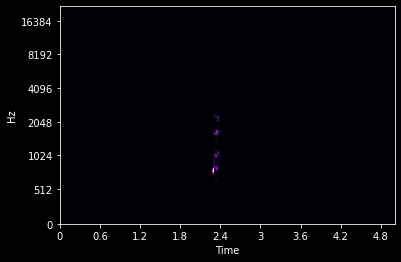

In [24]:
import librosa.display
librosa.display.specshow(spectogram, sr=sr, x_axis='time', y_axis='mel')

However, not a lot of information is present in the image, if we convert the spectogram to a logarithmic scale, we can see a lot more of the audio's structure, due to the scale being able to represent a wider range of values. And this is common enough in audio processing that *LibROSA* includes a method for it:

In [25]:
log_spectogram = librosa.power_to_db(spectogram, ref=np.max)

This computes a scaling factor of $10log_{10}(\frac{{spectogram}}{ref})$. ```ref``` defaults to ```1.0```, but here we're passing in ```np.max()``` so that ```spectogram/ref``` will fall within the range ```[0,1]```

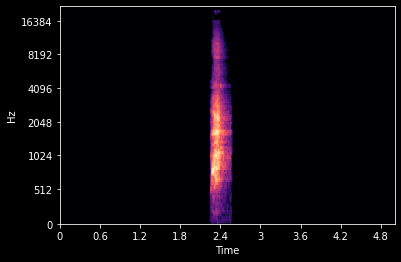

In [26]:
librosa.display.specshow(log_spectogram, sr=sr, x_axis='time', y_axis='mel')

In [27]:
log_spectogram.shape

(128, 431)

Checking at the shape of ```log_spectogram``` it is a 2D Tensor, which makes sense because we've plotted images with the tensor. We could create a new neural network architecture and feed this new data into it, but instead of working directly with the audio data, we could try working we the generated images from the spectograms.

It might seem silly at first; after all, we have the underlying spectogram data, and that's more exact than the image representation (to our eyes, knowing that a data point is 58 rather than 60 means *more* to us than a different shade of, say, purple). And if we were starting from scratch, that'd definely be the case. But! We have, just lying around the place, already-trained networks such as ResNet and Inception that we *know* are amazing at recognizing structure and other parts of images. We can construct image representations of our audio and use pretrained network to make big jumps in accuracy with very little training by using the super power of transfer learning once again. This could be useful with our dataset, as we don't have a lot of examples (only 2,000) to train our network.

This trick can be employed many disparate datasets. If you can find a way of cheaply turning tour data into an image representation, it's worth doing that and throwing a ResNet network against it to  get a baseline of what transfer learning can do for you, so you know what you have to beat by using a different approach. Armed with this, let's create a new dataset that will generate these images for us on demand.

# New Dataset

Now throw away the original ESC-50 dataset and build a new one, ```ESC50Spectrogram```. Although this will share some code with the older class, quite a lot more is going on in the ```___getitem___``` method in this version. We generate the spectogram by using *LibROSA* and then we do some fancy ```matplotlib``` footwork to get the data into a NumPy array. We apply the array to our transformation pipeline (which just uses ```ToTensor```) and return that and the item's label.

In [28]:
import torchvision
from PIL import Image
from torchvision import transforms

def precompute_spectogram(path, dpi=90):
    files = Path(path).glob('*.wav')
    for filename in files:
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectogram = librosa.feature.melspectrogram(audio_tensor, sr=sample_rate)
        log_spectogram = librosa.power_to_db(spectogram, ref=np.max)
        librosa.display.specshow(log_spectogram, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.gcf().savefig("{}{}_{}.png".format(filename.parent, dpi, filename.name), dpi=dpi)
        
class ESC50Spectogram(Dataset):
    
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}*.wav.png'.format(path.name))
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [29]:
# Run only if the spectograms aren't ready
# precompute_spectogram(PATH_TO_ESC50_train)
# precompute_spectogram(PATH_TO_ESC50_valid)
#precompute_spectogram(PATH_TO_ESC50_test) #Todo

The method in ```precompute_spectograms``` is simple, because we can use ```matplotlib savefig``` method to save a plot directly to disk rather than having to mess around with NumPy. We also provide an additional input parameter, ```dpi```, which allows us to control the quality of the genereted output.

# Using ResNet

As you may remember from Chapter 4, transfer learning requires that we take a model that has already been trained on a particular dataset (in the case of images, likely ImageNet), and then fine-tune it on our particular data domain, the ESC-50 dataset that we're turning into spectogram images. You might wondering whether a model is trained on *normal* photographs is any use to us. It turns out that the pretrained models do learn a lot of structure that can be applied to domains that a first glance might seem wildly different. Here's our code from Chapter 4 that initializes a model:

In [30]:
from torchvision import models
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False
    
spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features, 500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,50))

In [31]:
# del audionet, train_loader, valid_loader
# gc.collect()
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [32]:
device = 'cpu'
spec_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This initializes us with a pretrained (and frozen) ```ResNet50``` model and swaps out the head of the model for an untrained ```Sequential``` module that ends with a ```Linear``` with an output of 50, one for each of the classes in the ESC-50 dataset. We also need to create a ```DataLoader``` that takes our precomputed spectograms. When we create our ESC-50 dataset, we'll also want to normalize the incoming images with the standard  ```ImageNet``` standard deviation and mean, and that's what the pretrained ResNet-50 architecture was trained with. We can do this by passing in a new pipeline:

In [33]:
esc50pre_train = ESC50Spectogram(PATH_TO_ESC50_train,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50pre_valid = ESC50Spectogram(PATH_TO_ESC50_valid,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)
esc50pre_test = ESC50Spectogram(PATH_TO_ESC50_test, img_transforms=transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])]))

In [34]:
bs = 16
esc50pre_train_loader = DataLoader(esc50pre_train, batch_size=bs, shuffle=True, num_workers=2)
esc50pre_valid_loader = DataLoader(esc50pre_valid, batch_size=bs, shuffle=True, num_workers=2)
#esc50pre_test_loader = DataLoader(esc50pre_test, batch_size=bs, shuffle=True, num_workers=2)

With our dataloaders set up, we can  mode on to finding a learning rate and get ready to train

# Finding a Learning Rate

We need to find a learning rate to use in our model. As in Chapter 4, wel'll save the models initial parameters and use our ```find_lr()``` function to find a decent learning rate for training.

/home/leno/.local/share/virtualenvs/PyTorch-Im_YsN3d/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


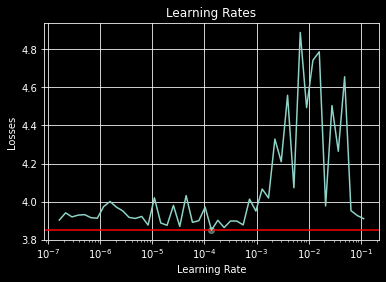

In [35]:
torch.save(spec_resnet.state_dict(), 'spec_resnet.pth')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(spec_resnet.parameters(), lr=1e-3)
logs, losses = find_lr(spec_resnet, loss_fn, optimizer, esc50pre_train_loader, device=device)

min_loss, opt_log = get_index_min(logs, losses)

fig, ax = plt.subplots()
ax.scatter(opt_log, min_loss, alpha=0.5)
ax.axhline(y=min_loss, color='r')
ax.semilogx(logs, losses)
ax.set(xlabel='Learning Rate', ylabel='Losses',
       title='Learning Rates')
ax.grid()
plt.show()

Looking at the graph of the learning rate plotted against loss, it seems like a ```lr``` close to ```1e-3``` is a good place to start. As our ResNet50 model is somewhat deeper than our previous one, we're also going to use differential learning rates of ```[1e-3, 1e-4,1e-8]```, with the highest learning rate applied to our classifier (as it requires the most training) and slower rates for the already-trained backbone. Again, we use Adam as our optimizer.

Before we apply those differential rates, though, we train for a few epochs that update only the classifier, as we *froze* the ResNet-50 backbone when we created our network:

In [39]:
spec_resnet.load_state_dict(torch.load('spec_resnet.pth'))
optimizer = torch.optim.Adam([
    {'params': spec_resnet.conv1.parameters()},
    {'params': spec_resnet.bn1.parameters()},
    {'params': spec_resnet.relu.parameters()},
    {'params': spec_resnet.maxpool.parameters()},
    {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
    {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
    {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
    {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
    {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
    {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}], lr=opt_log)
train(spec_resnet, optimizer, loss_fn, esc50pre_train_loader, esc50pre_valid_loader, epochs=5, device=device)

/tmp/ipykernel_181101/1476368462.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Now we unfreeze the backbone:

In [ ]:
for param in spec_resnet.parameters():
    param.requires_grad = True
train(spec_resnet, optimizer, loss_fn, esc50pre_train_loader, esc50pre_valid_loader, epochs=200, device=device)

<IPython.core.display.Javascript object>

/tmp/ipykernel_181101/1476368462.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
